# SKA Mid and Low Array Layout Simulations

The `ska_ost_array_config` Python package allows astronomers to define custom subarray configurations and perform some simple simulations with them. This notebook provides an overview of all the features provided by this package. The notebook is organized in the following way:

* [Define subarrays](#define_subarrays)

    * [Exclude stations](#exclude_stations)
    * [Distance-based filtering of subarrays](#station_filtering)
    * [The subarray template library](#subarray_templates)

* [Plot array layout](#plot_layout)
* [Plot collecting area vs baseline length](#area_per_bl)
* [Plot snapshot uv coverage](#plot_snapshot_uv)
* [Plot uv coverage for a generic observation](#plot_uv)
* [Compute PSF size](#compute_psf)

    * [Plot 1D profiles of the fitted PSF](#psf_profile)
    
* [Export CASA-compatible antenna list](#export_casa)
* [Specifying non-SKAO facilities](#external_telescopes)
* [Plots included in the memo](#memo_plots)

## Define subarrays <a class="anchor" id="define_subarrays"></a>

The LowSubArray and MidSubArray classes allow you to define Low and Mid subarrays respectively. 

In [1]:
from ska_ost_array_config.array_config import LowSubArray, MidSubArray

`ska_ost_array_config` currently supports three subarray types: `AA4` (or the design baseline), `AA*`, `AA2`, `AA1`, `AA0.5`, and `custom`. The subarray types with the `AA` prefix correspond to the different array assemblies. See the SKA staged delivery and array assemblies memo for more information.

Below are a few examples of how these subarray types can be instantiated:

In [2]:
low_aastar = LowSubArray(subarray_type="AA*")
low_aa4 = LowSubArray(subarray_type="AA4")
low_custom = LowSubArray(
    subarray_type="custom", custom_stations="C*,E1-*"
)  # selects all core stations and 6 stations in the E1 cluster

mid_aastar = MidSubArray(subarray_type="AA*")
mid_aa4 = MidSubArray(subarray_type="AA4")
mid_custom = MidSubArray(
    subarray_type="custom", custom_stations="M*,SKA017"
)  # selects all MeerKAT dishes and one of the MK+ dishes

Both LowSubArray and MidSubArray classes store the defined array configurations in the class member `array_config`, which is an object of type `ska_sdp_datamodels.configuration.config_model.Configuration`. It contains various information about the array layout including the station/dish names ( `low_aastar.array_config.names`) and the station/dish coordinates (`low_aastar.array_config`) in a local ENU frame. 

For example, in the case of `low_aastar`, you can access the array configuration as `low_aastar.array_config`.

In [3]:
low_aastar.array_config

<xarray.Configuration>
Dimensions:   (id: 307, spatial: 3)
Coordinates:
  * id        (id) int64 0 1 2 3 4 5 6 7 8 ... 299 300 301 302 303 304 305 306
  * spatial   (spatial) <U1 'X' 'Y' 'Z'
Data variables:
    names     (id) <U5 'C1' 'C10' 'C100' 'C101' ... 'S9-3' 'S9-4' 'S9-5' 'S9-6'
    xyz       (id, spatial) float64 124.0 -159.6 -17.97 ... -6.128e+03 -34.74
    diameter  (id) float64 38.0 38.0 38.0 38.0 38.0 ... 38.0 38.0 38.0 38.0 38.0
    mount     (id) <U2 'XY' 'XY' 'XY' 'XY' 'XY' ... 'XY' 'XY' 'XY' 'XY' 'XY'
    vp_type   (id) <U3 'LOW' 'LOW' 'LOW' 'LOW' 'LOW' ... 'LOW' 'LOW' 'LOW' 'LOW'
    offset    (id, spatial) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    stations  (id) <U3 '0' '1' '2' '3' '4' '5' ... '302' '303' '304' '305' '306'
Attributes:
    data_model:      Configuration
    name:            
    location:        (-2565044.42978869, 5085763.69674313, -2861062.43955626) m
    receptor_frame:  <ska_sdp_datamodels.science_data_model.polarisation_mode...
    frame:

**Note** that the array configuration object is compatible with [Radio Astronomy Simulation, Calibration, and Imaging Library (RASCIL)](https://developer.skao.int/projects/rascil/en/latest/index.html) if you wish to run your own simulations.

### Exclude stations <a class="anchor" id="exclude_stations"></a>

You can create a Low subarray containing all core stations except stations C1 and C2 by using the `exclude_stations` parameter as

In [4]:
low_custom = LowSubArray(
    subarray_type="custom", custom_stations="C*", exclude_stations="C1,C2"
)

In [5]:
mid_custom = MidSubArray(
    subarray_type="AA*", exclude_stations="M*"
)

### Distance-based filtering of subarrays <a class="anchor" id="station_filtering"></a>

The `ska_ost_array_config.array_config.filter_array_by_distance()` function allows you to filter stations/dishes in a subarray based on distance. 

The example below defines a Low subarray that contains all stations within a distance of 10 km from the array centre. 

In [6]:
from ska_ost_array_config.array_config import filter_array_by_distance
from astropy import units as u

low_all = LowSubArray(subarray_type="AA4")
low_inner_10k = filter_array_by_distance(low_all, distance=10000)
low_inner_10k = filter_array_by_distance(low_all, distance=10000 * u.m)

Note that distance can be specified either as an astropy quantity or without any units. In the absence of units, the specified distance will be assumed to be in metres.

The parameter `invert` allows you to exclude stations/dishes within the specified distance from the array centre. The example below defines a Mid subarray that contains all the Mid dishes that are beyond a distance of 100 km from the array centre.

In [7]:
mid_all = MidSubArray(subarray_type="AA4")
mid_outer_100k = filter_array_by_distance(mid_all, distance=100.0 * u.km, invert=True)

### The subarray template library <a class="anchor" id="subarray_templates"></a>

SKAO has defined a set of science-motivated subarray templates for both the Low and Mid telescopes. The class `ska_ost_array_config.array_config.SubarrayTemplateLibrary` provides an interface to the template library.

You can list all supported subarray templates with a call to the function `ska_ost_array_config.array_config.SubarrayTemplateLibrary.get_supported_templates()`.

You can then instantiate a subarray with its template name as shown below:

In [8]:
from ska_ost_array_config.array_config import SubarrayTemplateLibrary

subarray_1 = SubarrayTemplateLibrary().get_subarray_template(template_name="Mid_full_AA4")
subarray_2 = SubarrayTemplateLibrary().get_subarray_template(template_name="Low_full_AA4")
print(type(subarray_1), type(subarray_2))

<class 'ska_ost_array_config.array_config.MidSubArray'> <class 'ska_ost_array_config.array_config.LowSubArray'>


Note that, based on the template name, the returned subarray object is automatically determined to be of type `ska_ost_array_config.array_config.MidSubArray` or `ska_ost_array_config.array_config.LowSubArray`. 

Note that an `AssertionError` is raised if an unknown subarray template is passed to the function `ska_ost_array_config.array_config.SubarrayTemplateLibrary.get_subarray_template()`.

## Plot array layout <a class="anchor" id="plot_layout"></a>

Plots the layout of the array (in this case the `AA*` configuration created above). You can pass any valid `matplotlib.pyplot.scatter()` parameters to this function. Below are a few examples.

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='X (km)', ylabel='Y (km)'>)

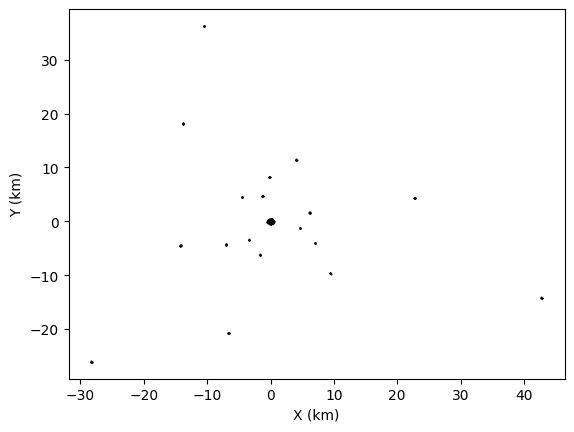

In [9]:
low_aastar.plot_array_layout()

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

low_aastar.plot_array_layout(axes[0], s=10)
axes[0].set_title("LOW AA*")

low_aa4.plot_array_layout(axes[1], s=10, c="green", marker="^")
axes[1].set_title("LOW AA4")

Text(0.5, 1.0, 'LOW AA4')

## Plot collecting area as a function of baseline length <a class="anchor" id="area_per_bl"></a>

Plots the collecting area as a function of baseline length. The number of baseline length bins can be controlled using the `n_bins` parameter (default: 50 bins).  You can pass any valid `matplotlib.pyplot.scatter()` parameters to this function. 

The example below plots the collecting area of the `AA*` configuration in 20 bins. 

/Users/s.sridhar/Library/Caches/pypoetry/virtualenvs/ska-ost-array-config-ffAgvIi0-py3.10/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  super().__init__(data_vars, coords=coords, attrs=attrs)


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Baseline length (km)', ylabel='Collecting area (sq. m)'>)

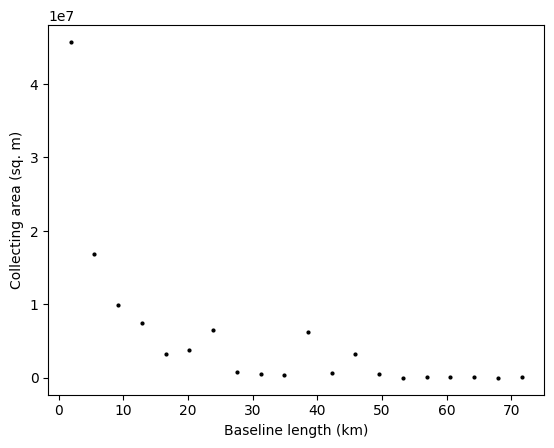

In [11]:
low_aastar.plot_collecting_area_vs_bl_length(n_bins=20)

You can normalize the y-axis by setting `normalization=True`.

In [12]:
low_aastar.plot_collecting_area_vs_bl_length(n_bins=20, normalization=True)

/Users/s.sridhar/Library/Caches/pypoetry/virtualenvs/ska-ost-array-config-ffAgvIi0-py3.10/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  super().__init__(data_vars, coords=coords, attrs=attrs)


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Baseline length (km)', ylabel='Normalized collecting area (%)'>)

## Plot snapshot uv coverage <a class="anchor" id="plot_snapshot_uv"></a>

Plots the snapshot uv coverage for a source at zenith. You can pass any valid `matplotlib.pyplot.scatter()` parameters to this function. Below are a few examples.

In [13]:
low_aastar.plot_snapshot_zenith_uvcov(
    ref_freq=50e6,
    chan_width=5.4e3,
    n_chan=1,
    freq_undersample=100,
    method="metre",
    plot_conj=True,
)

/Users/s.sridhar/Library/Caches/pypoetry/virtualenvs/ska-ost-array-config-ffAgvIi0-py3.10/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  super().__init__(data_vars, coords=coords, attrs=attrs)


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='U (km)', ylabel='V (km)'>,
 <ska_ost_array_config.UVW.UVW at 0x139e74490>)

Same as above but this time plot the uv coverage in k$\lambda$ units. **Note** here that when simulating with large numbers of frequency channels, you might be memory-limited. In that case, use the `freq_undersample`. The example below simulates every 100th channel within the full LOW continuum band.

In [14]:
low_aastar.plot_snapshot_zenith_uvcov(
    ref_freq=50e6,
    chan_width=5.4e3,
    n_chan=55296,
    freq_undersample=100,
    method="lambda",
    scale="kilo",
    plot_conj=True,
)

/Users/s.sridhar/Library/Caches/pypoetry/virtualenvs/ska-ost-array-config-ffAgvIi0-py3.10/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  super().__init__(data_vars, coords=coords, attrs=attrs)


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='U (k$\\lambda$)', ylabel='V (k$\\lambda$)'>,
 <ska_ost_array_config.UVW.UVW at 0x1396d3940>)

If you want to plot the conjugates using a different colour and a different symbol, use the `c_conj` and `marker_conj` keys.

/Users/s.sridhar/Library/Caches/pypoetry/virtualenvs/ska-ost-array-config-ffAgvIi0-py3.10/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  super().__init__(data_vars, coords=coords, attrs=attrs)


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='U (k$\\lambda$)', ylabel='V (k$\\lambda$)'>,
 <ska_ost_array_config.UVW.UVW at 0x13ca5a290>)

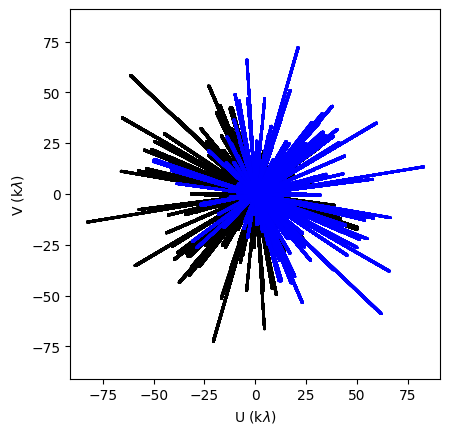

In [15]:
low_aastar.plot_snapshot_zenith_uvcov(
    ref_freq=50e6,
    chan_width=5.4e3,
    n_chan=55296,
    freq_undersample=100,
    method="lambda",
    scale="kilo",
    plot_conj=True,
    c_conj="b",
    marker_conj="^",
)

## Plot uv coverage for a generic observation <a class="anchor" id="plot_uv"></a>

`ska_ost_array_config.simulation_utils.simulate_observation()` allows you to simulate a generic observation with LOW and MID telescopes. Note that it only generates the meta data for the observation and not the visibilities themselves. Also note that there is no explicit warning if the specified source is below the horizon; when this happens, the corresponding row is flagged. 

The example below simulates a 1-hour MID AA* observation with 1000 channels with the frequency of the first channel being 1420 MHz.

In [16]:
from ska_ost_array_config.simulation_utils import simulate_observation
from astropy.coordinates import SkyCoord
from astropy import units
from astropy.time import Time
from ska_ost_array_config.UVW import UVW

phase_centre = SkyCoord("08:00:00 -75:00:00", unit=(units.hourangle, units.deg))

observation = simulate_observation(
    array_config=MidSubArray(subarray_type="AA*", exclude_stations="SKA008").array_config,
    phase_centre=phase_centre,
    start_time=Time.now(),
    duration=3600.0,
    integration_time=1,
    ref_freq=1420e6,
    chan_width=13.4e3,
    n_chan=1000,
    horizon=20,
    freq_undersample=100,
    time_undersample=10,
)

uvw = UVW(observation, ignore_autocorr=True)

/Users/s.sridhar/Library/Caches/pypoetry/virtualenvs/ska-ost-array-config-ffAgvIi0-py3.10/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  super().__init__(data_vars, coords=coords, attrs=attrs)


You can then plot the uv-coverage of the simulated observation with `UVW.plot_uv_coverage()`. 

In [17]:
from ska_ost_array_config.UVW import plot_uv_coverage

fig, axes = plot_uv_coverage(uvw)

You can also plot histograms of the baseline distributions. The example below plots the histograms of baseline distribution in metres (left panel) and in lambda (right panel).

In [18]:
from ska_ost_array_config.UVW import plot_baseline_distribution

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

plot_baseline_distribution(uvw, axes[0], method="metre", plot_type="u", label="u")
plot_baseline_distribution(uvw, axes[0], method="metre", plot_type="v", label="v")
plot_baseline_distribution(
    uvw, axes[0], method="metre", plot_type="uv", label="uv dist"
)
axes[0].legend()

plot_baseline_distribution(uvw, axes[1], method="lambda", plot_type="u", label="u")
plot_baseline_distribution(uvw, axes[1], method="lambda", plot_type="v", label="v")
plot_baseline_distribution(
    uvw, axes[1], method="lambda", plot_type="uv", label="uv dist"
)
axes[1].legend()

## Compute PSF size <a class="anchor" id="compute_psf"></a>

The `ska_ost_array_config.array_config.simulation_utils.generate_mfs_psf()` allows you to estimate the MFS PSF corresponding to a given set of uvw coordinates. The example below showcases how to extract the MFS PSF size corresponding to Briggs weighting with robust parameter set to -1. 

In [19]:
from ska_ost_array_config.simulation_utils import generate_mfs_psf

pixel_size = uvw.get_cellsize(over_sample=5)
psf = generate_mfs_psf(
    observation, pixel_size, npixel=1024, weighting="robust", r_value=-1
)

`generate_mfs_psf()` returns the PSF an object of type `ska_sdp_datamodels.image.image_model.Image`. You can then use the function `ska_ost_array_config.simulation_utils.get_PSF_shape_and_profile()` to fit a Gaussian to the PSF and extract the values for BMAJ and BMIN as shown below:

In [20]:
from ska_ost_array_config.simulation_utils import get_PSF_shape_and_profile

psf_size = get_PSF_shape_and_profile(psf)
print(
    f"PSF size (arcsec): {psf_size['bmaj']*3600.:0.2f} x {psf_size['bmin']*3600.:0.2f}"
)
print(f"BPA: {psf_size['bpa']:0.2f} deg")

PSF size (arcsec): 1.88 x 1.21
BPA: -208.98 deg


### Plot 1D profiles of the fitted PSF <a class="anchor" id="psf_profile"></a>

In addition to getting the FWHM of the fitted PSF, `get_PSF_shape_and_profile()` can be used to extract a 1D profile of the PSF along its major and minor axes. 

In [21]:
psf_size, (major_profile, minor_profile) = get_PSF_shape_and_profile(
    psf, return_profile=True
)

# Plot the 1D profiles along the major and minor axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(minor_profile[412:612])  # Plot the inner 200 pixels
ax1.set_xlabel("Pixels along the minor axis")
ax1.set_ylabel("|PSF|")
ax2.plot(major_profile[412:612])  # Plot the inner 200 pixels
ax2.set_xlabel("Pixels along the major axis")
fig.align_ylabels()
plt.show()

## Export CASA-compatible antenna list  <a class="anchor" id="export_casa"></a>

If you wish to run simulations using CASA's simutil module, you can export the antenna list using generate_casa_antenna_list(). For example,

In [22]:
low_aastar.generate_casa_antenna_list("low.txt")
mid_aastar.generate_casa_antenna_list("mid.txt")

## Specifying non-SKAO facilities <a class="anchor" id="external_telescopes"></a>

Sometimes it might be useful to include non-SKAO facilities to simulate VLBI-type experiments. You can define external facilities as objects to class `ska_ost_array_config.simulation_utils.ExternalTelescope` and add them to the subarrays using the `external_telescopes` parameter while defining the `LowSubArray` and `MidSubArray` classes. **Note** that this is not a valid observing mode with SKAO telescopes. This functionality is provided in the code purely for running simulations.

The example below defines a subarray that includes all SKA LOW stations in the core along with two non-existent stations located at ATCA and ASKAP.

In [23]:
from astropy.coordinates import EarthLocation
from ska_ost_array_config.simulation_utils import ExternalTelescope

askap = ExternalTelescope(
    label="askap",
    location=EarthLocation.from_geodetic(lon=116.637, lat=-26.696),
    station_diameter=10.
)

atca_w196 = ExternalTelescope(
    label="atca_w196",
    location=EarthLocation.from_geodetic(
        lon=149.5489798, lat=-30.3144576, height=209.3
    ),
    station_diameter=10.
)

low_test = LowSubArray(
    subarray_type="custom", custom_stations="C*", external_telescopes=[askap, atca_w196]
)

print("Stations in the subarray:", ",".join(low_test.array_config.names.data))

Stations in the subarray: C1,C10,C100,C101,C102,C103,C104,C105,C106,C107,C108,C109,C11,C110,C111,C112,C113,C114,C115,C116,C117,C118,C119,C12,C120,C121,C122,C123,C124,C125,C126,C127,C128,C129,C13,C130,C131,C132,C133,C134,C135,C136,C137,C138,C139,C14,C140,C141,C142,C143,C144,C145,C146,C147,C148,C149,C15,C150,C151,C152,C153,C154,C155,C156,C157,C158,C159,C16,C160,C161,C162,C163,C164,C165,C166,C167,C168,C169,C17,C170,C171,C172,C173,C174,C175,C176,C177,C178,C179,C18,C180,C181,C182,C183,C184,C185,C186,C187,C188,C189,C19,C190,C191,C192,C193,C194,C195,C196,C197,C198,C199,C2,C20,C200,C201,C202,C203,C204,C205,C206,C207,C208,C209,C21,C210,C211,C212,C213,C214,C215,C216,C217,C218,C219,C22,C220,C221,C222,C223,C224,C23,C24,C25,C26,C27,C28,C29,C3,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C4,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C5,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C6,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C7,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C8,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C9,C9

You can then plot, for example, the array layout and snapshot uv coverage as follows

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Plot the array layout
low_test.plot_array_layout(
    axes=axes[0][0],
    scale="kilo",
    s=4,
)
axes[0][0].set_title("Custom array layout")

# Plot snapshot uv coverage for a fiduccial source at zenith
uvw = low_test.plot_snapshot_zenith_uvcov(
    axes=axes[0][1],
    ref_freq=200e6,
    chan_width=5.4e3,
    n_chan=1,
    method="metre",
    plot_conj=True,
)
axes[0][1].set_title("Snapshot uv coverage")

# Make a histogram of the baseline distribution
plot_baseline_distribution(
    uvw,
    axes=axes[1][0],
    method="lambda",
    scale="kilo",
    plot_type="uv",
    label="uv distance",
)
axes[1][0].set_title("Baseline distribution")

# Plot collecting area as a function of baseline length
low_test.plot_collecting_area_vs_bl_length(
    n_bins=20, axes=axes[1][1], normalization=True
)
axes[1][1].set_title("Collecting area")

/Users/s.sridhar/Library/Caches/pypoetry/virtualenvs/ska-ost-array-config-ffAgvIi0-py3.10/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  super().__init__(data_vars, coords=coords, attrs=attrs)
/Users/s.sridhar/Library/Caches/pypoetry/virtualenvs/ska-ost-array-config-ffAgvIi0-py3.10/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning:

Text(0.5, 1.0, 'Collecting area')

## Plots included in the memo <a class="anchor" id="memo_plots"></a>

**Staged delivery: Figure 1**

In [25]:
from ska_ost_array_config.array_config import MidSubArray
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import numpy

font = 18
plt.rcParams["font.size"] = font
plt.rcParams["axes.titlesize"] = font
plt.rcParams["axes.labelsize"] = font
plt.rcParams["xtick.labelsize"] = font
plt.rcParams["ytick.labelsize"] = font

fig, axes = plt.subplots(1, 3, figsize=(14,5), sharey=True)

# mid AA4 configuration
mid_aa4 = MidSubArray(subarray_type="AA4")
mid_aa4.plot_array_layout(
    axes=axes[2], 
    scale="kilo",
    s=4,
)
axis_limit = numpy.max([
    numpy.max(numpy.absolute(axes[2].get_xlim())),
    numpy.max(numpy.absolute(axes[2].get_ylim()))
])
axis_limit += 0.01 * axis_limit
axes[2].set_xlim(-axis_limit, axis_limit)
axes[2].set_ylim(-axis_limit, axis_limit)
axes[2].set_aspect("equal")
axes[2].set_box_aspect(1)
axes[2].xaxis.set_major_locator(MaxNLocator(nbins=5))
axes[2].yaxis.set_major_locator(MaxNLocator(nbins=5))
axes[2].set_title("AA4 array layout")
axes[2].set_ylabel("")

# mid AA* configuration
mid_aastar = MidSubArray(subarray_type="AA*")
mid_aastar.plot_array_layout(
    axes=axes[1], 
    scale="kilo",
    s=4,
)
axes[1].set_xlim(-axis_limit, axis_limit)
axes[1].set_ylim(-axis_limit, axis_limit)
axes[1].set_aspect("equal")
axes[1].set_box_aspect(1)
axes[1].xaxis.set_major_locator(MaxNLocator(nbins=5))
axes[1].yaxis.set_major_locator(MaxNLocator(nbins=5))
axes[1].set_title("AA* array layout")
axes[1].set_ylabel("")

# mid AA2 configuration
mid_aa2 = MidSubArray(subarray_type="AA2")
mid_aa2.plot_array_layout(
    axes=axes[0], 
    scale="kilo",
    s=4,
)
axes[0].set_xlim(-axis_limit, axis_limit)
axes[0].set_ylim(-axis_limit, axis_limit)
axes[0].set_aspect("equal")
axes[0].set_box_aspect(1)
axes[0].xaxis.set_major_locator(MaxNLocator(nbins=5))
axes[0].yaxis.set_major_locator(MaxNLocator(nbins=5))
axes[0].set_title("AA2 array layout")
axes[0].set_ylabel("")

plt.tight_layout()
plt.savefig('mid_array_layout.png', dpi=300)

**Staged delivery: Figure 2**

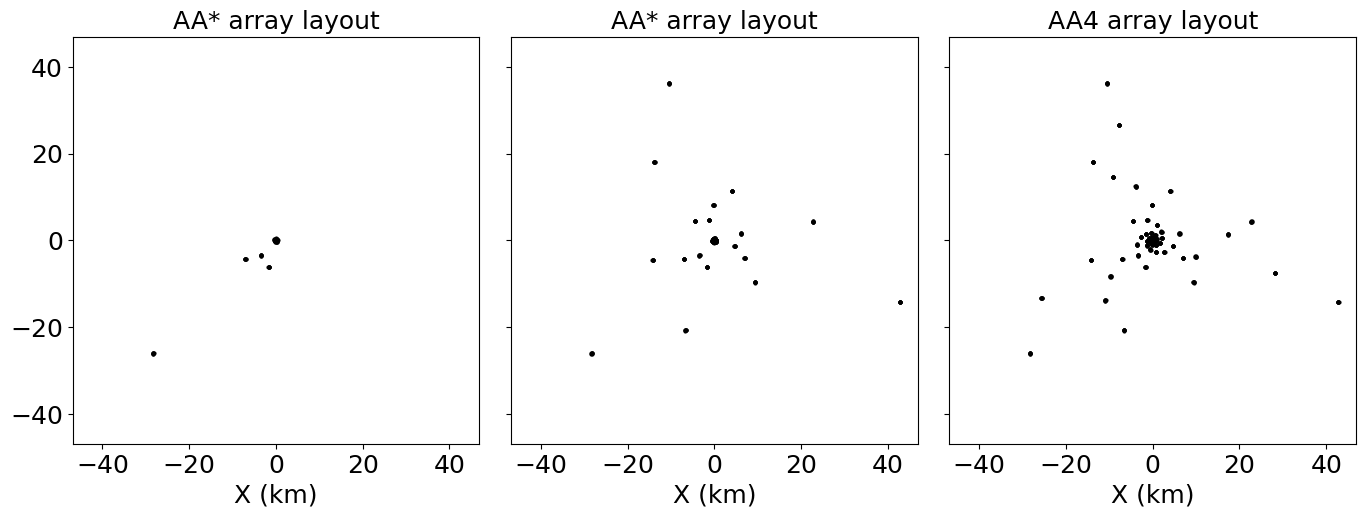

In [26]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

font = 18
plt.rcParams["font.size"] = font
plt.rcParams["axes.titlesize"] = font
plt.rcParams["axes.labelsize"] = font
plt.rcParams["xtick.labelsize"] = font
plt.rcParams["ytick.labelsize"] = font

from ska_ost_array_config.array_config import LowSubArray

fig, axes = plt.subplots(1, 3, figsize=(14,5), sharey=True)

# LOW AA4 configuration
low_aa4 = LowSubArray(subarray_type="AA4")
low_aa4.plot_array_layout(
    axes=axes[2], 
    scale="kilo",
    s=4,
)
axis_limit = numpy.max([
    numpy.max(numpy.absolute(axes[2].get_xlim())),
    numpy.max(numpy.absolute(axes[2].get_ylim()))
])
axis_limit += 0.01 * axis_limit
axes[2].set_xlim(-axis_limit, axis_limit)
axes[2].set_ylim(-axis_limit, axis_limit)
axes[2].set_aspect("equal")
axes[2].set_box_aspect(1)
axes[2].xaxis.set_major_locator(MaxNLocator(nbins=5))
axes[2].yaxis.set_major_locator(MaxNLocator(nbins=5))
axes[2].set_title("AA4 array layout")
axes[2].set_ylabel("")

# LOW AA* configuration
low_aastar = LowSubArray(subarray_type="AA*")
low_aastar.plot_array_layout(
    axes=axes[1], 
    scale="kilo",
    s=4,
)
axes[1].set_xlim(-axis_limit, axis_limit)
axes[1].set_ylim(-axis_limit, axis_limit)
axes[1].set_aspect("equal")
axes[1].set_box_aspect(1)
axes[1].xaxis.set_major_locator(MaxNLocator(nbins=5))
axes[1].yaxis.set_major_locator(MaxNLocator(nbins=5))
axes[1].set_title("AA* array layout")
axes[1].set_ylabel("")

# LOW AA2 configuration
low_aa2 = LowSubArray(subarray_type="AA2")
low_aa2.plot_array_layout(
    axes=axes[0], 
    scale="kilo",
    s=4,
)
axes[0].set_xlim(-axis_limit, axis_limit)
axes[0].set_ylim(-axis_limit, axis_limit)
axes[0].set_aspect("equal")
axes[0].set_box_aspect(1)
axes[0].xaxis.set_major_locator(MaxNLocator(nbins=5))
axes[0].yaxis.set_major_locator(MaxNLocator(nbins=5))
axes[0].set_title("AA* array layout")
axes[0].set_ylabel("")

plt.tight_layout()
plt.savefig('low_array_layout.png', dpi=300)

**Staged delivery: Section A.1**

/Users/s.sridhar/Library/Caches/pypoetry/virtualenvs/ska-ost-array-config-ffAgvIi0-py3.10/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  super().__init__(data_vars, coords=coords, attrs=attrs)


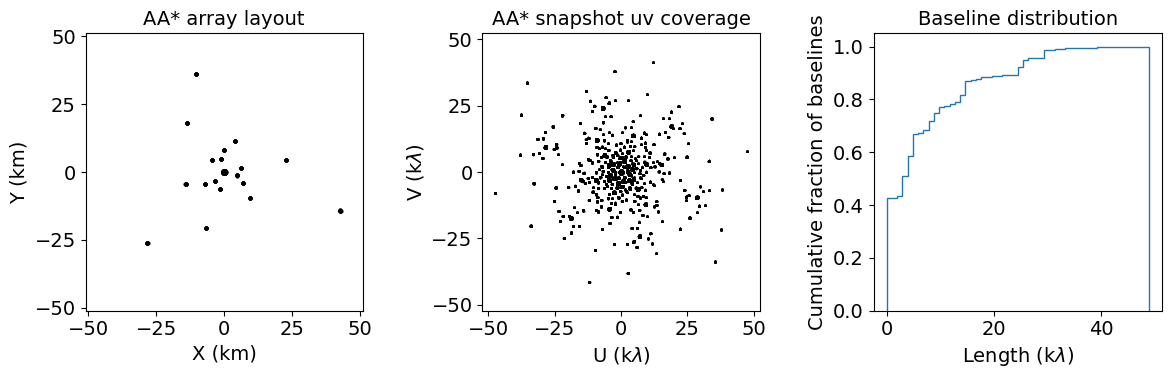

In [27]:
from ska_ost_array_config.array_config import LowSubArray
from ska_ost_array_config.UVW import plot_baseline_distribution
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy

font = 14
plt.rcParams["font.size"] = font
plt.rcParams["axes.titlesize"] = font
plt.rcParams["axes.labelsize"] = font
plt.rcParams["xtick.labelsize"] = font
plt.rcParams["ytick.labelsize"] = font

# Create a subarray containing all Low stations in
# AA* configuration
low_aastar = LowSubArray(subarray_type="AA*")

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot the array layout
low_aastar.plot_array_layout(
    axes=axes[0],
    scale="kilo",
    s=4,
)
axis_limit = numpy.max([
    numpy.max(numpy.absolute(axes[0].get_xlim())),
    numpy.max(numpy.absolute(axes[0].get_ylim()))
])
axis_limit += 0.1 * axis_limit
axes[0].set_xlim(-axis_limit, axis_limit)
axes[0].set_ylim(-axis_limit, axis_limit)
axes[0].set_aspect("equal")
axes[0].set_box_aspect(1)
axes[0].xaxis.set_major_locator(MaxNLocator(nbins=5))
axes[0].yaxis.set_major_locator(MaxNLocator(nbins=5))
axes[0].set_title("AA* array layout")

# Plot snapshot uv coverage for a fiduccial source at zenith
uvw = low_aastar.plot_snapshot_zenith_uvcov(
    axes=axes[1],
    ref_freq=200e6,
    chan_width=5.4e3,
    n_chan=1,
    method="lambda",
    plot_conj=True,
)
axes[1].set_aspect("equal")
axes[1].set_box_aspect(1)
axes[1].xaxis.set_major_locator(MaxNLocator(nbins=5))
axes[1].yaxis.set_major_locator(MaxNLocator(nbins=5))
axes[1].set_title("AA* snapshot uv coverage")

# Make a histogram of the baseline distribution
plot_baseline_distribution(
    uvw,
    axes=axes[2],
    method="lambda",
    scale="kilo",
    plot_type="uv",
    label="uv distance",
)
axes[2].set_title("Baseline distribution")

plt.tight_layout()
plt.savefig('low_aastar.png', dpi=300)

**Staged delivery: section A.2**

In [28]:
from ska_ost_array_config.array_config import MidSubArray, filter_array_by_distance
from ska_ost_array_config.UVW import UVW, plot_baseline_distribution, plot_uv_coverage
from ska_ost_array_config.simulation_utils import (
    find_rise_set_times,
    simulate_observation,
)
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from astropy import units
from astropy.time import Time, TimeDelta
import numpy

# Create a custom MID array using all dishes within 1 km from the array centre
mid_aastar = MidSubArray(subarray_type="AA*")
custom_stations = filter_array_by_distance(mid_aastar, 1000.0 * units.m)
mid_custom = MidSubArray(subarray_type="custom", custom_stations=custom_stations)

# Define the pointing centre
lmc = SkyCoord("05:23:34 -69:45:00", unit=(units.hourangle, units.deg))

# Find the UTC time when the source transits
_, transit_time, _ = find_rise_set_times(
    location=mid_custom.array_config.location,
    phase_centre=lmc,
    date=Time.now(),
    elevation_limit=20.0,
)

# Simulate the observation and get the uvw values
duration = 7200.0  # in seconds
observation = simulate_observation(
    array_config=mid_custom.array_config,
    phase_centre=lmc,
    start_time=transit_time - TimeDelta(duration / 2, format="sec"),
    duration=duration,
    integration_time=1,
    ref_freq=950e6,
    chan_width=13.44e3,
    n_chan=1,  # 60628,
    horizon=20,
    freq_undersample=200,
    time_undersample=20,
)
uvw = UVW(observation, ignore_autocorr=True)

del observation

/Users/s.sridhar/Library/Caches/pypoetry/virtualenvs/ska-ost-array-config-ffAgvIi0-py3.10/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  super().__init__(data_vars, coords=coords, attrs=attrs)


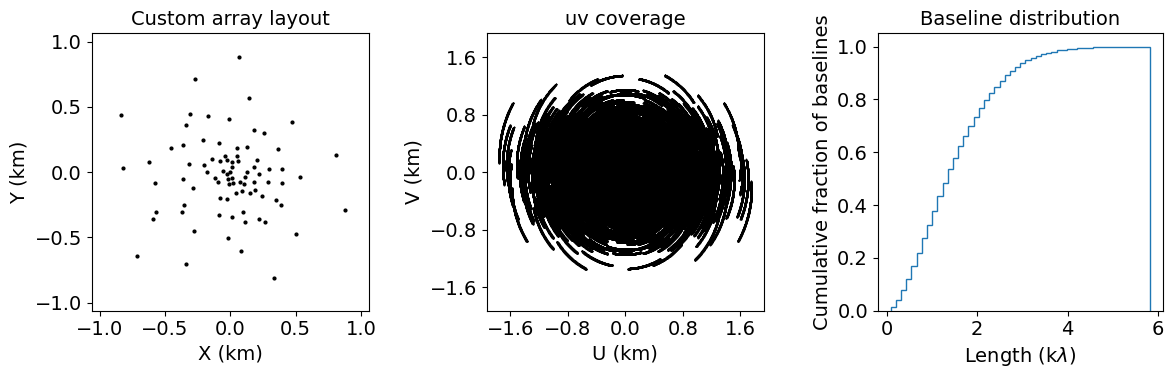

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot the array layout
mid_custom.plot_array_layout(
    axes=axes[0],
    scale="kilo",
    s=4,
)
axis_limit = numpy.max([
    numpy.max(numpy.absolute(axes[0].get_xlim())),
    numpy.max(numpy.absolute(axes[0].get_ylim()))
])
axis_limit += 0.1 * axis_limit
axes[0].set_xlim(-axis_limit, axis_limit)
axes[0].set_ylim(-axis_limit, axis_limit)
axes[0].set_aspect("equal")
axes[0].set_box_aspect(1)
axes[0].xaxis.set_major_locator(MaxNLocator(nbins=5))
axes[0].yaxis.set_major_locator(MaxNLocator(nbins=5))
axes[0].set_title("Custom array layout")

# Plot the UV coverage
plot_uv_coverage(uvw, axes=axes[1], method="metre", scale="kilo", plot_conj=True)
axes[1].set_aspect("equal")
axes[1].set_box_aspect(1)
axes[1].xaxis.set_major_locator(MaxNLocator(nbins=5))
axes[1].yaxis.set_major_locator(MaxNLocator(nbins=5))
axes[1].set_title("uv coverage")

# Plot the baseline distribution
plot_baseline_distribution(
    uvw,
    axes=axes[2],
    method="lambda",
    scale="kilo",
    plot_type="uv",
    label="uv distance",
)
axes[2].set_title("Baseline distribution")

plt.tight_layout()
plt.savefig('mid_custom.png', dpi=300)

**Subarray templates: section A**

In [30]:
from ska_ost_array_config.UVW import (
    UVW, 
    plot_baseline_distribution, 
    plot_uv_coverage
)
from ska_ost_array_config.simulation_utils import (
    find_rise_set_times,
    simulate_observation,
)
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
from matplotlib.ticker import MaxNLocator
from astropy import units
from astropy.time import Time, TimeDelta
from ska_ost_array_config.array_config import SubarrayTemplateLibrary

subarray = SubarrayTemplateLibrary().get_subarray_template(
    template_name="Mid_inner_r500m_AA4"
)

In [31]:
# Define the pointing centre
lmc = SkyCoord("05:23:34 -69:45:00", unit=(units.hourangle, units.deg))

# Find the UTC time when the source transits
_, transit_time, _ = find_rise_set_times(
    location=subarray.array_config.location,
    phase_centre=lmc,
    date=Time.now(),
    elevation_limit=20.0,
)

# Simulate the observation and get the uvw values
duration = 7200.0  # in seconds
observation = simulate_observation(
    array_config=subarray.array_config,
    phase_centre=lmc,
    start_time=transit_time - TimeDelta(duration / 2, format="sec"),
    duration=duration,
    integration_time=1,
    ref_freq=950e6,
    chan_width=13.44e3,
    n_chan=1,  # 60628,
    horizon=20,
    freq_undersample=200,
    time_undersample=20,
)
uvw = UVW(observation, ignore_autocorr=True)

del observation

/Users/s.sridhar/Library/Caches/pypoetry/virtualenvs/ska-ost-array-config-ffAgvIi0-py3.10/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  super().__init__(data_vars, coords=coords, attrs=attrs)


In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), layout="constrained")

# Plot the array layout
subarray.plot_array_layout(
    axes=axes[0],
    scale="kilo",
    s=4,
)
axes[0].set_xlim([-0.5, 0.5])
axes[0].set_ylim([-0.5, 0.5])
axes[0].set_box_aspect(1)
axes[0].set_title("mid_inner_r500m_AA4 layout")

# Plot the UV coverage
plot_uv_coverage(uvw, axes=axes[1], method="metre", scale="kilo", plot_conj=True)
axes[1].set_title("uv coverage")
axes[1].set_xlim([-1, 1])
axes[1].set_ylim([-1, 1])
axes[1].xaxis.set_major_locator(MaxNLocator(nbins=5))
axes[1].yaxis.set_major_locator(MaxNLocator(nbins=5))
axes[1].set_box_aspect(1)

# Plot the baseline distribution
plot_baseline_distribution(
    uvw,
    axes=axes[2],
    method="lambda",
    scale="kilo",
    plot_type="uv",
    label="uv distance",
)
axes[2].set_title("Baseline distribution")

plt.savefig('mid_inner_r500m_AA4.png', dpi=300)